In [1]:
# %pip install ipywidgets

import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from torchvision.utils import make_grid
import numpy as np
from IPython.display import clear_output

import matplotlib.gridspec as gridspec


# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [3]:
assert torch.cuda.is_available()

In [2]:
latent_dimension = 128
batch_size = 32
n_epochs = 500
image_size = 32 # CIFAR10 is 32x32. This MUST be a power of 2 for these architectures to work
workers = 2
num_channels = 3  # RGB
lr = 0.002
beta1 = 0.5
g_feat_map_size = 32
d_feat_map_size = 32

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    
    def __init__(self, image_size, latent_dimension, feat_map_size, num_channels):
        
        super(Generator, self).__init__()

        # The following defines the architecture in a way that automatically
        # scale the number of blocks depending on the size of the input image

        # Number of blocks between the first and the last (excluded)
        n_blocks = int(np.log2(image_size)) - 3

        # Initial multiplicative factor for the number of feature maps
        factor = 2**(n_blocks)

        # The first block takes us from the latent space to the feature space with a
        # 4x4 kernel with stride 1 and no padding
        blocks = [
            self._get_transpconv_block(latent_dimension, feat_map_size*factor, 4, 1, 0)
        ]

        # The following blocks are transposed convolutional layers with stride 2 and
        # kernel size 4x4. Every block halves the number of feature maps but double the
        # size of the image (upsampling)
        # (NOTE that we loop in reverse order)
        prev_dim = feat_map_size*factor
        for f in range(int(np.log2(factor)-1), -1, -1):
            blocks.append(
                self._get_transpconv_block(prev_dim, feat_map_size*2**f, 4, 2, 1)
            )
            prev_dim = feat_map_size*2**f

        # Add last layer
        blocks.append(
            self._get_transpconv_block(feat_map_size, num_channels, 4, 2, 1, nn.Tanh)
        )

        self.model = nn.Sequential(
            *blocks
            # self._get_transpconv_block(latent_dimension, feat_map_size*4, 4, 1, 0),
            # self._get_transpconv_block(feat_map_size*4, feat_map_size*2, 4, 2, 1),
            # self._get_transpconv_block(feat_map_size*2, feat_map_size, 4, 2, 1),
            # self._get_transpconv_block(feat_map_size, num_channels, 4, 2, 1, nn.Tanh),
        )
    
    def _get_transpconv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation=nn.ReLU):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding
        ),
            nn.BatchNorm2d(out_channels),
            activation()
        )

    # forward method
    def forward(self, latents):
        return self.model(latents)

In [5]:
G = Generator(image_size, latent_dimension, g_feat_map_size, num_channels)

NameError: name 'Generator' is not defined

In [ ]:
x = torch.randn(1, latent_dimension, 1, 1)
for i in range(len(G.model)):
    x = G.model[i](x)
    print(x.shape)

torch.Size([1, 128, 4, 4])
torch.Size([1, 64, 8, 8])
torch.Size([1, 32, 16, 16])
torch.Size([1, 3, 32, 32])


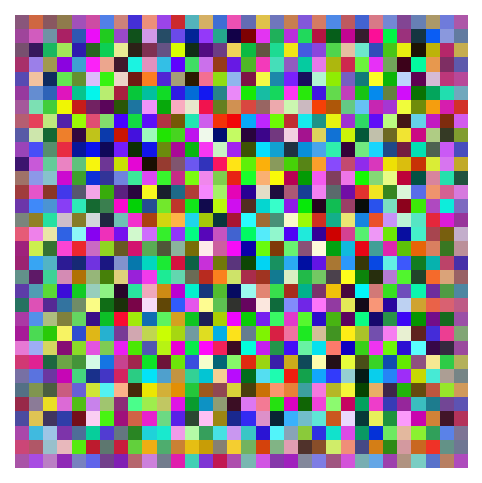

In [ ]:
# Visualize the output tensor as a grayscale image
def visualize_batch(batch):
    fig, sub = plt.subplots(dpi=150)
    sub.imshow(
        np.transpose(
            make_grid(
                batch.detach().cpu(), 
                padding=2,
                normalize=True
            ).cpu(),
            (1,2,0)
        )
    )
    _ = sub.axis("off")

z = torch.randn(1, latent_dimension, 1, 1)
visualize_batch(G(z))

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, image_size, feat_map_size, num_channels):

        super(Discriminator, self).__init__()

        blocks = []

        prev_dim = num_channels
        for i in range(int(np.log2(image_size))-2):
            blocks.append(
                self._get_conv_block(prev_dim, feat_map_size*(2**i), 4, 2, 1, nn.LeakyReLU(0.2, inplace=True))
            )
            prev_dim = feat_map_size*(2**i)
        
        blocks.append(
            self._get_conv_block(prev_dim, 1, 4, 1, 0, nn.Sigmoid())
        )

        # NOTE: the paper suggests to use strided convolution instead of max pooling
        # to pool the feature maps
        self.model = nn.Sequential(
            *blocks
            # self._get_conv_block(num_channels, feat_map_size, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            # self._get_conv_block(feat_map_size, feat_map_size*2, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            # self._get_conv_block(feat_map_size*2, feat_map_size*4, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            # self._get_conv_block(feat_map_size*4, feat_map_size*8, 4, 2, 1, nn.LeakyReLU(0.2, inplace=True)),
            # self._get_conv_block(feat_map_size*8, 1, 4, 1, 0, nn.Sigmoid()),
        )
    
    def _get_conv_block(self, in_channels, out_channels, kernel_size, stride, padding, activation):

        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels, 
                kernel_size=kernel_size, 
                stride=stride, 
                padding=padding,
                bias=False
        ),
            nn.BatchNorm2d(out_channels),
            activation
        )

    # forward method
    def forward(self, images):
        return self.model(images)

In [ ]:
# Set BatchNorm to eval mode so it will work on batch 1
D = Discriminator(image_size, d_feat_map_size, num_channels).eval()

In [6]:
img = torch.randn((1, num_channels, image_size, image_size))
D(img)

NameError: name 'D' is not defined

In [7]:
# Setup CIFAR10 dataset

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(
    root="./data",
    download=True,
    train=True,
    transform=transform
)

# Get indices of samples with label 2 (birds)
car_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]

# Create a subset using those indices
car_subset = torch.utils.data.Subset(dataset, car_indices)

dataloader = torch.utils.data.DataLoader(car_subset, batch_size=batch_size, shuffle=True, num_workers=workers)

visualize_batch(next(iter(dataloader))[0])

Files already downloaded and verified


NameError: name 'visualize_batch' is not defined

In [ ]:
len(dataloader) * batch_size

5024

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Setup optimization
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(16, latent_dimension, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
_ = D.to(device)
_ = D.apply(weights_init)
_ = G.to(device)
_ = G.apply(weights_init)

NameError: name 'D' is not defined

In [8]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(n_epochs):
    # For each batch in the dataloader
    batch_G_losses = []
    batch_D_losses = []

    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dimension, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        # if i % 50 == 0:
        #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #           % (epoch, n_epochs, i, len(dataloader),
        #              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        batch_G_losses.append(errG.item())
        batch_D_losses.append(errD.item())

        # # Check how the generator is doing by saving G's output on fixed_noise
        # if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = G(fixed_noise).detach().cpu()
        #     img_list.append(make_grid(fake, padding=2, normalize=True))

        # iters += 1

    G_losses.append(np.mean(batch_G_losses))
    D_losses.append(np.mean(batch_D_losses))

    with torch.no_grad():
        fake = G(fixed_noise).detach().cpu()
    
    clear_output(wait=True)
    fig, subs = plt.subplots(1, 2, dpi=150)

    gs = gridspec.GridSpec(2, 2)

    # Create subplots
    ax_a = fig.add_subplot(gs[0, 0])  # Top-left subplot
    ax_b = fig.add_subplot(gs[1, 0])  # Bottom-left subplot
    ax_c = fig.add_subplot(gs[:, 1])  # Right subplot spanning both rows

    subs = [ax_a, ax_b, ax_c]
    
    subs[0].plot(G_losses, label="Generator")
    subs[0].plot(D_losses, label="Discriminator")
    subs[0].legend()
    subs[0].set_xlabel("Iteration")
    subs[0].set_ylabel("Loss")
    subs[0].set_title("Losses")

    # Now plot the accuracy
    # subs[1].plot([D_x, D_G_z1, D_G_z2])

    subs[2].imshow(
        np.transpose(
            make_grid(
                fake.detach().cpu(), 
                padding=2,
                normalize=True,
                nrow=4
            ).cpu(),
            (1,2,0)
        )
    )
    subs[2].axis("off")
    plt.show()

    fig.savefig(f"epoch_{epoch}.png", bbox_inches='tight')

Starting Training Loop...


NameError: name 'D' is not defined

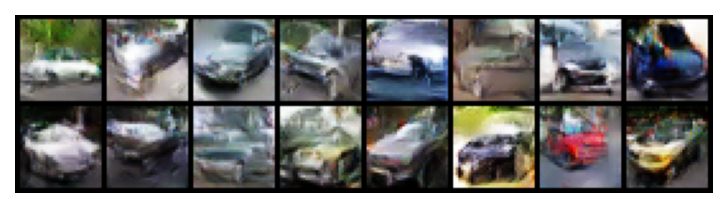

In [ ]:
visualize_batch(fake)